In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data_models.basic import Tabular, LOCOData, LinearData, MultiClass
from models.basic import SVM, LogisticReg, RandForestRegressor
from conformal_prediction.basic import SimpleConformal
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict

In [3]:
multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
multi_data.X_y_split(y='y')

In [34]:
logistic = LogisticRegression()
logistic.fit(multi_data.train_data_X, multi_data.train_data_y)

LogisticRegression()

In [ ]:
# In this approach we exploit how simple the conformal prediction is for discrete classes and only train the model once (the variable to drop will be replaced with 0's)
boot_coverage = defaultdict(list)
boot_size = defaultdict(list)

B = 10

for i in range(B):

    if i % 50 == 0:
        print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    logistic = RandomForestClassifier()
    logistic.fit(multi_data.train_data_X, multi_data.train_data_y)

    for variable in multi_data.train_data_X.columns:

        simple_conformal = SimpleConformal(alpha=0.05, type='adaptive')
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=logistic)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=logistic, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)
        print(pred_all[:10])

        data_X_j = copy.copy(multi_data.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(multi_data.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=logistic)
        pred_j = simple_conformal.predict(data=data_X_test_j, model=logistic, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)
        print(pred_j[:10])

        boot_coverage[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])

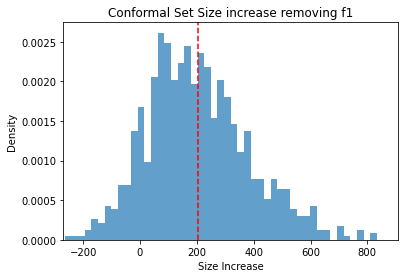

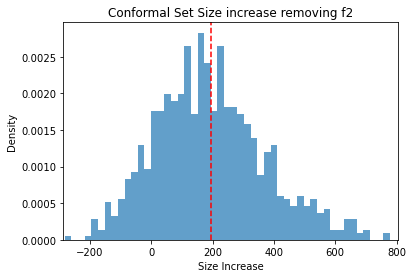

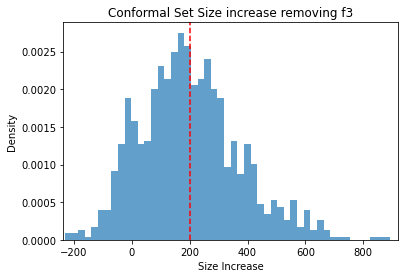

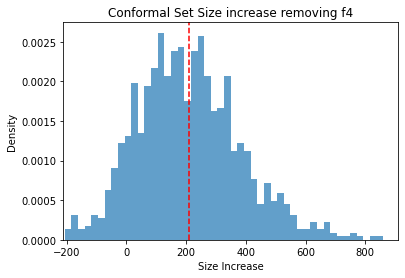

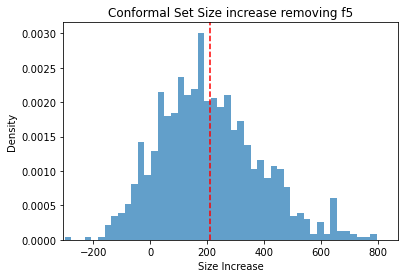

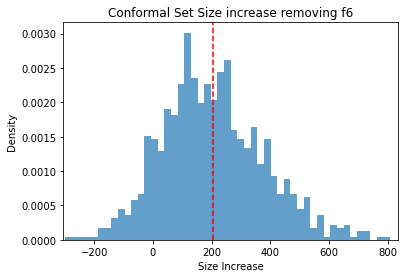

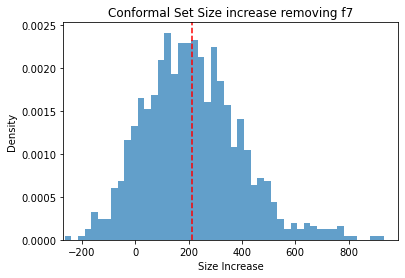

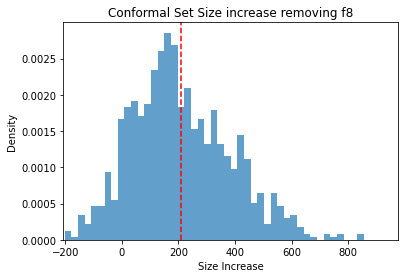

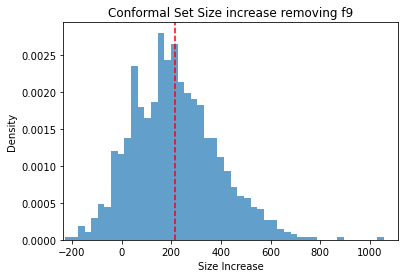

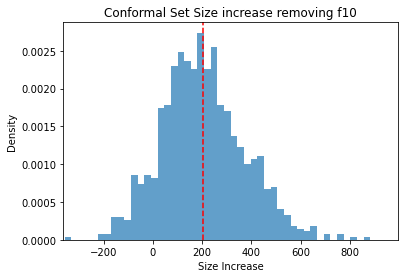

In [125]:
import numpy as np
from matplotlib import pyplot as plt

for variable in multi_data.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images\Multi_data\conformal_set_size_increase_' + variable)
    plt.show()

In [133]:
boot_coverage = defaultdict(list)
boot_size = defaultdict(list)

B = 1000

for i in range(B):

    if i % 50 == 0:
        print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    logistic_all = LogisticRegression(max_iter=1000)
    logistic_all.fit(multi_data.train_data_X, multi_data.train_data_y)

    for variable in multi_data.train_data_X.columns:

        data_X_j_train = copy.copy(multi_data.train_data_X)
        data_X_j_train = data_X_j_train.loc[:, data_X_j_train.columns!=variable]
        data_X_j_calib = copy.copy(multi_data.calib_data_X)
        data_X_j_calib = data_X_j_calib.loc[:, data_X_j_calib.columns!=variable]
        data_X_j_test = copy.copy(multi_data.test_data_X)
        data_X_j_test= data_X_j_test.loc[:, data_X_j_test.columns!=variable]

        logistic_j = LogisticRegression(max_iter=1000)
        logistic_j.fit(data_X_j_train, multi_data.train_data_y)

        simple_conformal = SimpleConformal(alpha=0.95)
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=logistic_all)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=logistic_all, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

        lambda_j = simple_conformal.calibrate(data_X=data_X_j_calib, data_y=multi_data.calib_data_y, model=logistic_j)
        pred_j = simple_conformal.predict(data=data_X_j_test, model=logistic_j, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

        boot_coverage[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


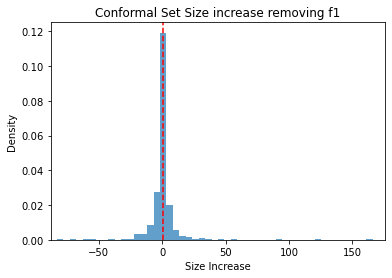

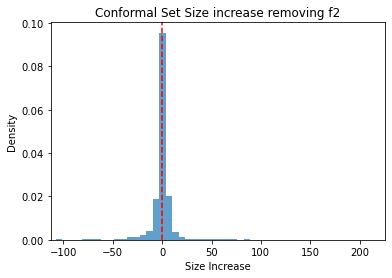

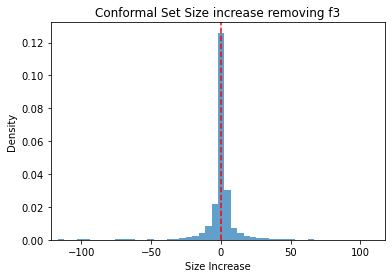

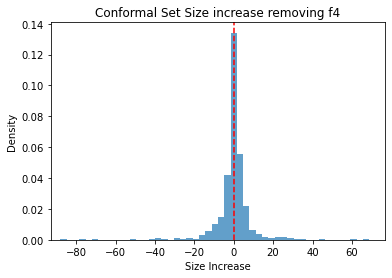

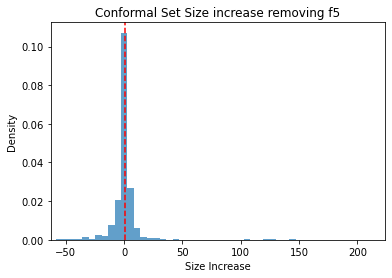

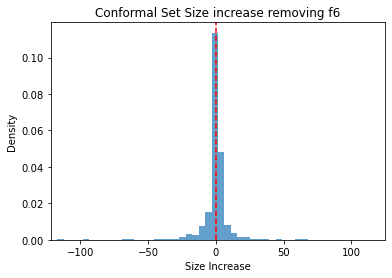

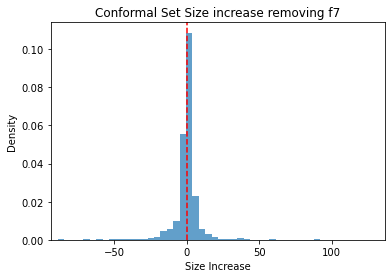

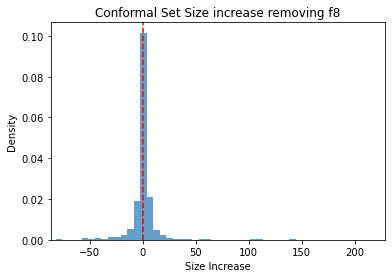

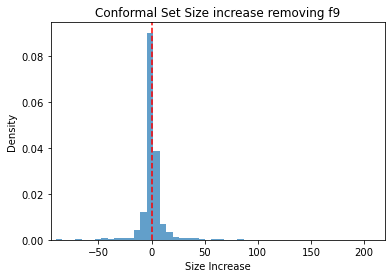

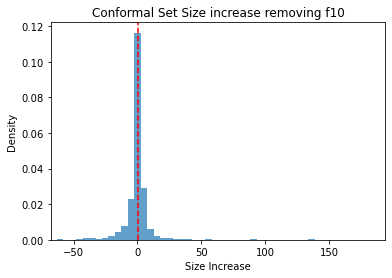

In [138]:
import numpy as np
from matplotlib import pyplot as plt

for variable in multi_data.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images\Multi_data\conformal_retrain_set_size_increase_' + variable)
    plt.show()

In [ ]:
# Do the alpha analysis once again
plot = None
B = 100

average_size = defaultdict(list)

for variable in multi_data.calib_data_X.columns:
    print(variable)
    for alpha in np.arange(0.6, 1, 0.01):
        if (alpha*100) % 10 == 0:
            print(alpha)
        temp = 0
        for i in range(B):

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            logistic = LogisticRegression()
            logistic.fit(multi_data.train_data_X, multi_data.train_data_y)
            
            simple_conformal = SimpleConformal(alpha=alpha)
            lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=logistic, method='normal')
            pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=logistic, lambda_conformal=lambda_all)
            cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

            data_X_j = copy.copy(multi_data.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(multi_data.test_data_X)
            data_X_test_j[variable] = 0

            lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=logistic)
            pred_j = simple_conformal.predict(data=data_X_test_j, model=logistic, lambda_conformal=lambda_j)
            cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

            temp += size_j-size_all
        average_size[variable].extend([temp/B])

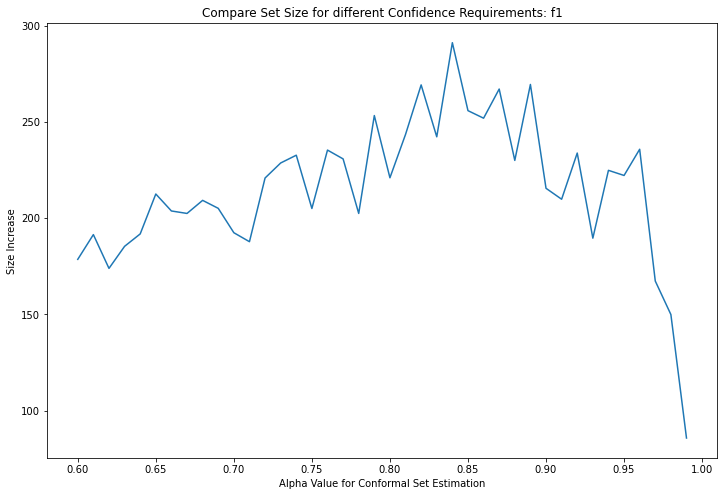

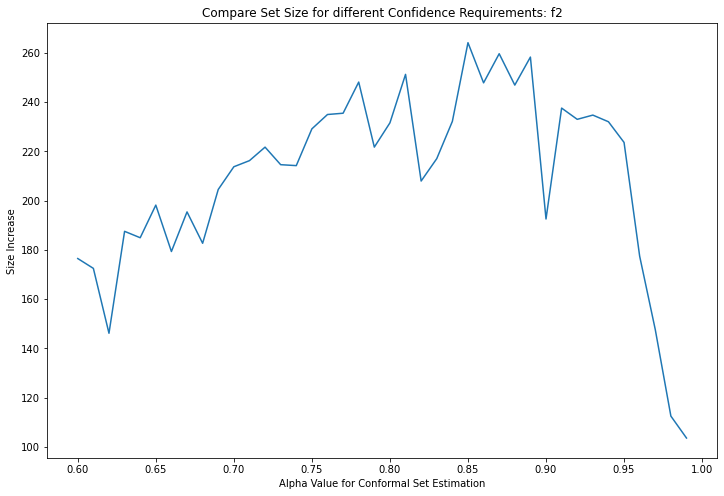

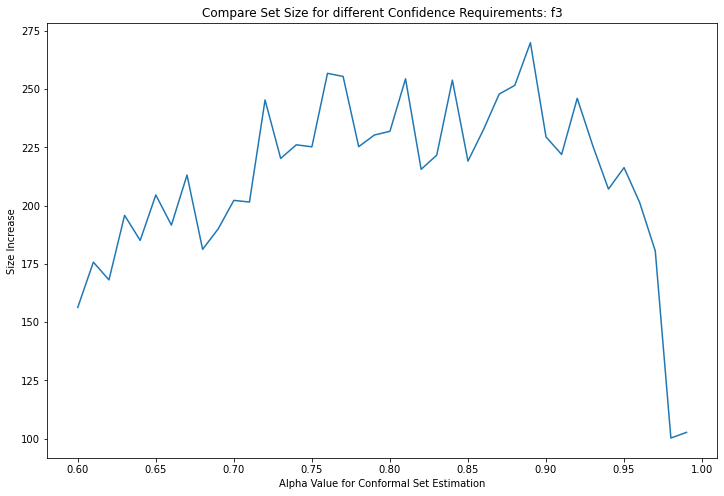

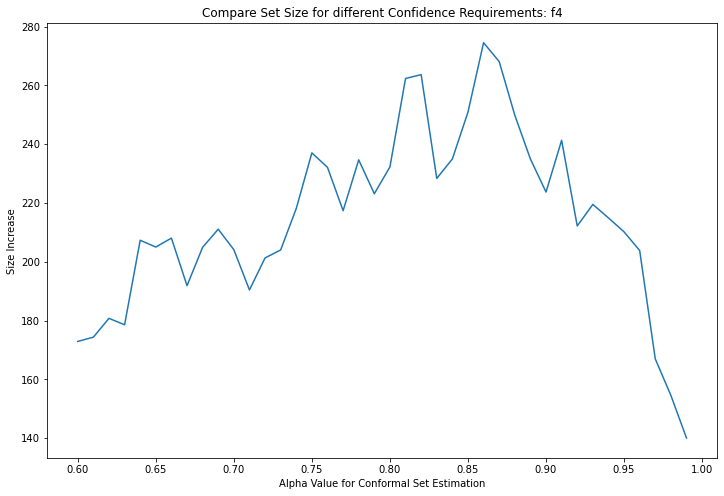

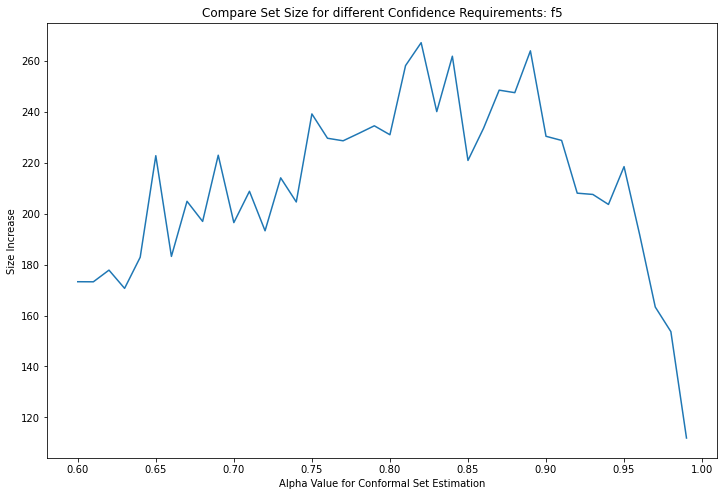

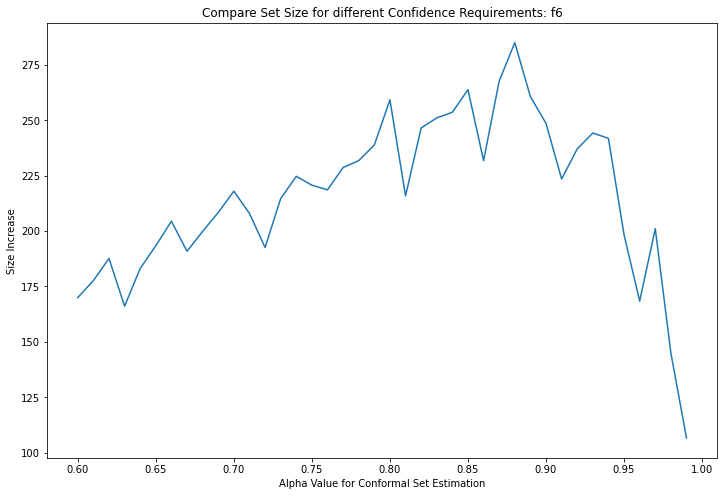

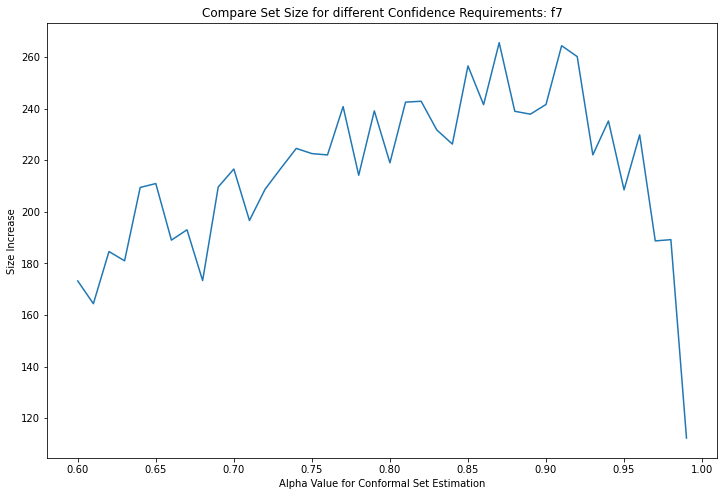

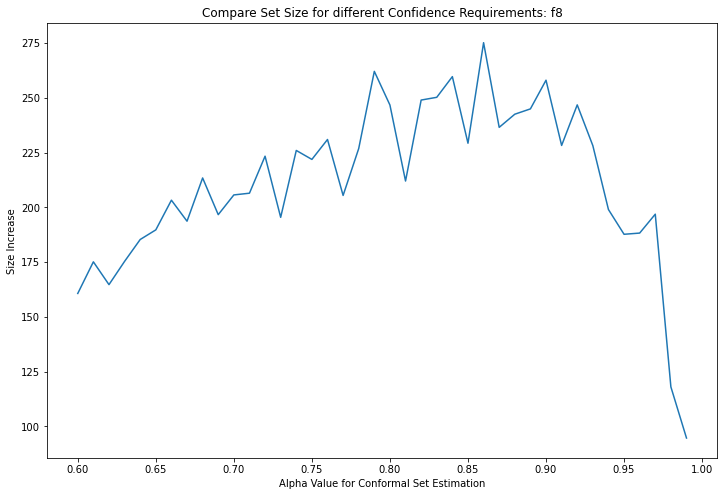

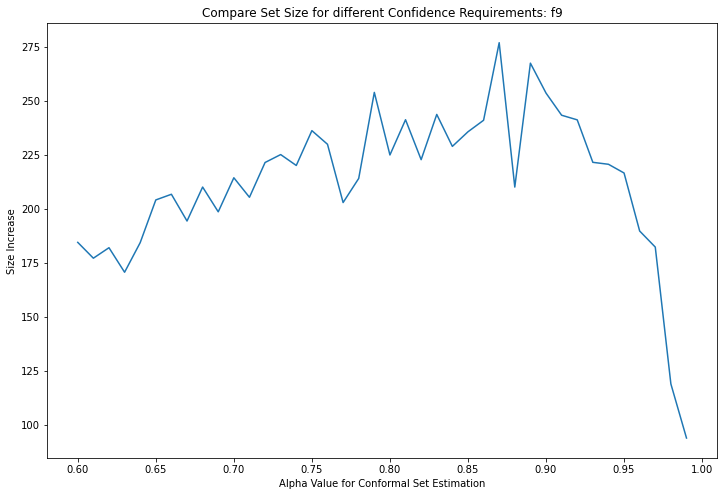

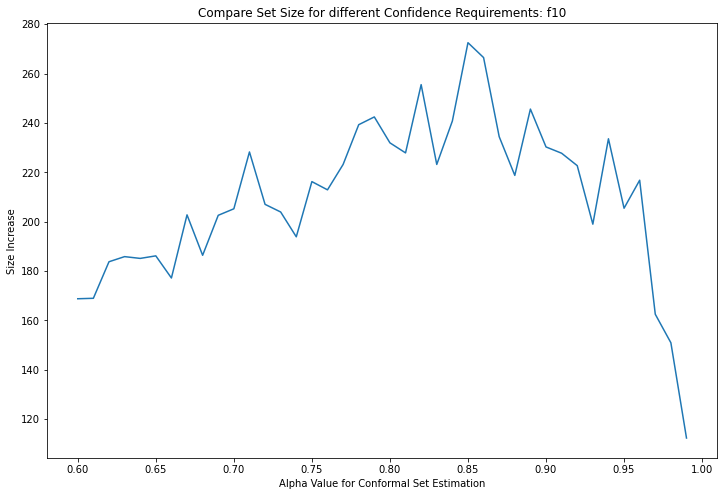

In [145]:
for variable in multi_data.calib_data_X.columns:
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0.6, 1, 0.01), average_size[variable])
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable)
    plt.savefig('images/Multi_data/alpha_grid_' + variable)
    plt.show();

### See what is the issue...

In [370]:
# In this approach we exploit how simple the conformal prediction is for discrete classes and only train the model once (the variable to drop will be replaced with 0's)

boot_coverage = defaultdict(list)
boot_size = defaultdict(list)

B = 10

for i in range(B):

    if i % 50 == 0:
        print(i)

    multi_data = multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10, class_sep=1)
    multi_data.X_y_split(y='y')

    model = RandomForestClassifier()
    model.fit(multi_data.train_data_X, multi_data.train_data_y)

    for variable in multi_data.train_data_X.columns:

        simple_conformal = SimpleConformal(alpha=0.05, type='adaptive')
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

        data_X_j = copy.copy(multi_data.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(multi_data.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
        pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

        boot_coverage[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])

0


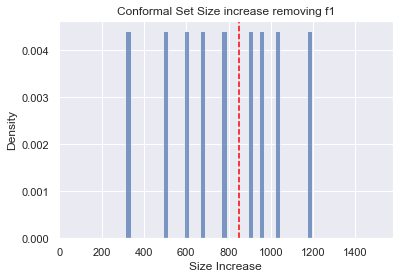

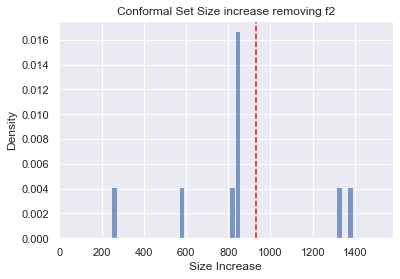

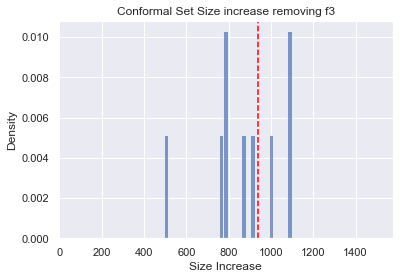

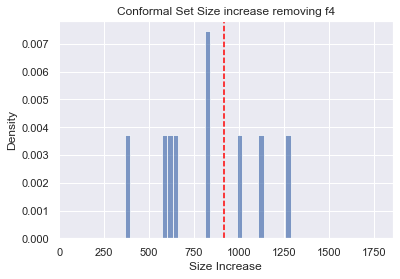

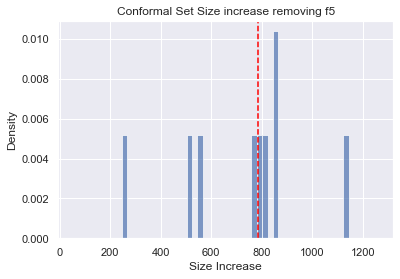

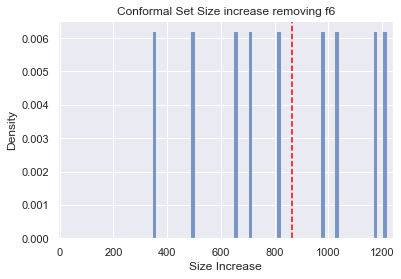

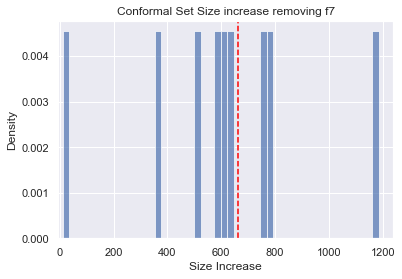

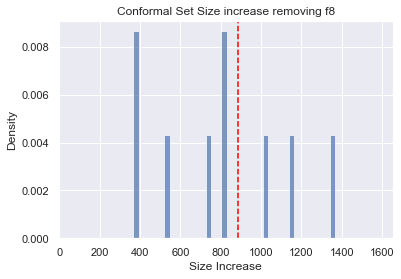

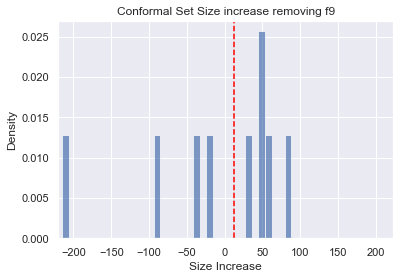

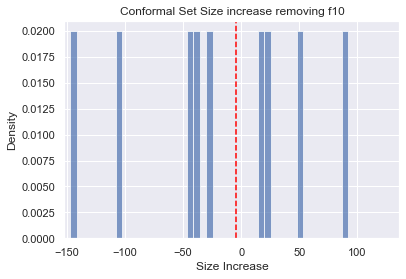

In [371]:
import numpy as np
from matplotlib import pyplot as plt

for variable in multi_data.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    # plt.savefig('images/Multi_data/adaptive_randomforest_conformal_set_size_increase_' + variable)
    plt.show()

In [ ]:
boot_coverage = defaultdict(list)
boot_size = defaultdict(list)

B = 5

for i in range(B):

    if i % 10 == 0:
        print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    logistic_all = LogisticRegression(max_iter=1000)
    logistic_all.fit(multi_data.train_data_X, multi_data.train_data_y)

    for variable in multi_data.train_data_X.columns:

        data_X_j_train = copy.copy(multi_data.train_data_X)
        data_X_j_train = data_X_j_train.loc[:, data_X_j_train.columns!=variable]
        data_X_j_calib = copy.copy(multi_data.calib_data_X)
        data_X_j_calib = data_X_j_calib.loc[:, data_X_j_calib.columns!=variable]
        data_X_j_test = copy.copy(multi_data.test_data_X)
        data_X_j_test= data_X_j_test.loc[:, data_X_j_test.columns!=variable]

        logistic_j = LogisticRegression(max_iter=1000)
        logistic_j.fit(data_X_j_train, multi_data.train_data_y)

        simple_conformal = SimpleConformal(alpha=0.05, type='adaptive')
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=logistic_all)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=logistic_all, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)
        print(cov_all)

        lambda_j = simple_conformal.calibrate(data_X=data_X_j_calib, data_y=multi_data.calib_data_y, model=logistic_j)
        pred_j = simple_conformal.predict(data=data_X_j_test, model=logistic_j, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

        boot_coverage[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])

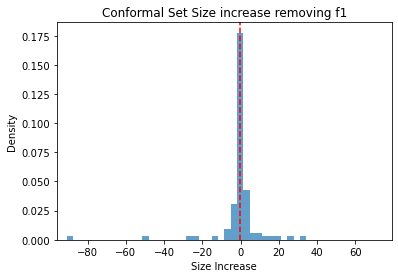

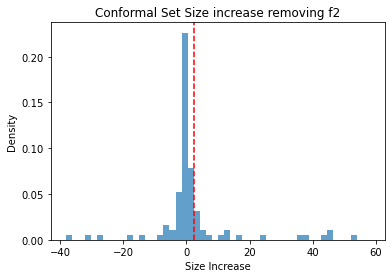

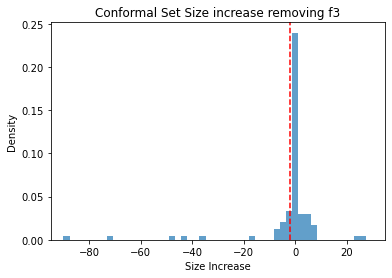

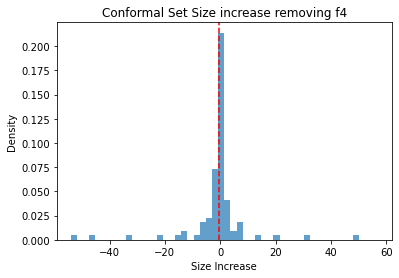

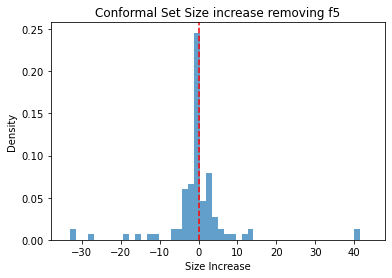

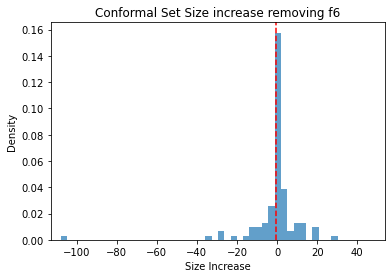

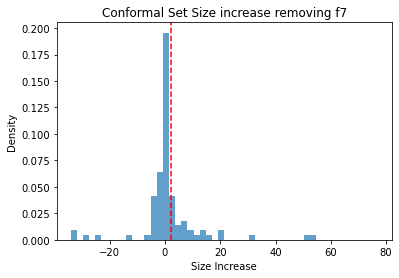

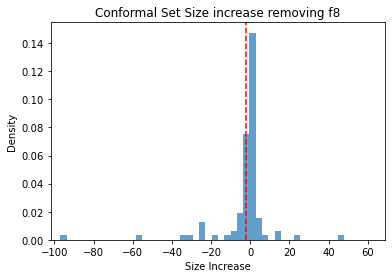

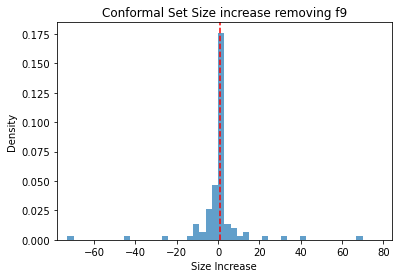

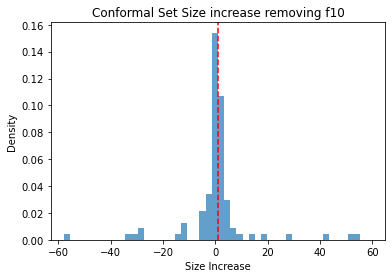

In [281]:
import numpy as np
from matplotlib import pyplot as plt

for variable in multi_data.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images/Multi_data/adaptive_retrain_logistic_conformal_set_size_increase_' + variable)
    plt.show()

In [282]:
# Last chance before we look into different data is to use a Gaussian Mixture Model
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


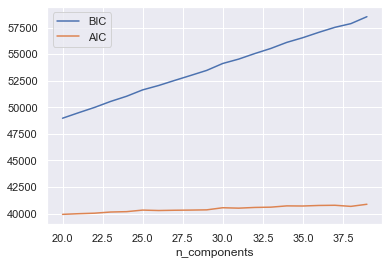

In [287]:
n_components = np.arange(20, 40)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(multi_data.train_data_X, multi_data.train_data_y) for n in n_components]
plt.plot(n_components, [m.bic(multi_data.train_data_X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(multi_data.train_data_X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
boot_coverage = defaultdict(list)
boot_size = defaultdict(list)

B = 10

for i in range(B):

    if i % 1 == 0:
        print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    model = GaussianMixture(n_components=10)
    model.fit(multi_data.train_data_X, multi_data.train_data_y)

    for variable in multi_data.train_data_X.columns:

        simple_conformal = SimpleConformal(alpha=0.05, type='adaptive')
        lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
        pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

        data_X_j = copy.copy(multi_data.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(multi_data.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
        pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

        print('lambda_all: ', lambda_all)
        print('lambda_j: ', lambda_j)
        print('cov_all: ', cov_all)
        print('cov_j: ', cov_j)

        boot_coverage[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

for variable in multi_data.calib_data_X.columns:

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable)
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images/Multi_data/adaptive_randomforest_conformal_set_size_increase_' + variable)
    plt.show()

### Now that we have found the issue

In [ ]:
# In this approach we exploit how simple the conformal prediction is for discrete classes and only train the model once (the variable to drop will be replaced with 0's)
for comb in [['logistic', 'normal', 'once'], ['logistic', 'adaptive', 'once'], ['randomforest', 'adaptive', 'once'], ['randomforest', 'adaptive', 'twice']]: 
    print(comb)
    model_type = comb[0]
    conformal_type = comb[1]
    train = comb[2]

    boot_coverage = defaultdict(list)
    boot_size = defaultdict(list)

    B = 1000

    if train == 'once':

        for i in range(B):

            if i % 50 == 0:
                print(i)

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            if model_type == 'logistic':
                model = LogisticRegression()
            elif model_type == 'randomforest':
                model = RandomForestClassifier()
            model.fit(multi_data.train_data_X, multi_data.train_data_y)

            for variable in multi_data.train_data_X.columns:

                simple_conformal = SimpleConformal(alpha=0.05, type=conformal_type)
                lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
                pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
                cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

                data_X_j = copy.copy(multi_data.calib_data_X)
                data_X_j[variable] = 0
                data_X_test_j = copy.copy(multi_data.test_data_X)
                data_X_test_j[variable] = 0

                lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
                pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
                cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

                boot_coverage[variable].extend([cov_j])
                boot_size[variable].extend([size_j-size_all])

    else:

        for i in range(B):

            if i % 50 == 0:
                print(i)

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            if model_type == 'logistic':
                model_all = LogisticRegression(max_iter=1000)
            elif model_type == 'randomforest':
                model_all = RandomForestClassifier()
            model_all.fit(multi_data.train_data_X, multi_data.train_data_y)

            for variable in multi_data.train_data_X.columns:

                data_X_j_train = copy.copy(multi_data.train_data_X)
                data_X_j_train = data_X_j_train.loc[:, data_X_j_train.columns!=variable]
                data_X_j_calib = copy.copy(multi_data.calib_data_X)
                data_X_j_calib = data_X_j_calib.loc[:, data_X_j_calib.columns!=variable]
                data_X_j_test = copy.copy(multi_data.test_data_X)
                data_X_j_test= data_X_j_test.loc[:, data_X_j_test.columns!=variable]

                if model_type == 'logistic':
                    model_j = LogisticRegression(max_iter=1000)
                elif model_type == 'randomforest':
                    model_j = RandomForestClassifier()
                model_j.fit(data_X_j_train, multi_data.train_data_y)

                simple_conformal = SimpleConformal(alpha=0.05, type=conformal_type)
                lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model_all)
                pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model_all, lambda_conformal=lambda_all)
                cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

                lambda_j = simple_conformal.calibrate(data_X=data_X_j_calib, data_y=multi_data.calib_data_y, model=model_j)
                pred_j = simple_conformal.predict(data=data_X_j_test, model=model_j, lambda_conformal=lambda_j)
                cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

                boot_coverage[variable].extend([cov_j])
                boot_size[variable].extend([size_j-size_all])


    for variable in multi_data.calib_data_X.columns:

        data = boot_size[variable] 

        # fixed bin size
        bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

        plt.xlim([min(0, min(data))-5, max(data)+5])

        plt.hist(data, bins=bins, alpha=0.7, density=True)
        plt.axvline(x=np.mean(data), color='red', linestyle='--')
        plt.title('Conformal Set Size increase removing ' + variable)
        plt.xlabel('Size Increase')
        plt.ylabel('Density')
        plt.savefig('images\Multi_data_correct\size_inc_' + model_type + '_' + conformal_type + '_' + train + '_' + variable)
        plt.show()

In [ ]:
# Alpha grid trend
# What happens if we go over different alpha values?
plot = None
B = 50

average_size = defaultdict(list)
ci_dict = {}

for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    print(variable)
    ci = []
    for alpha in np.arange(0.6, 1, 0.01):
        if (round(alpha, 2)*100) % 5 == 0:
            print(alpha)
        temp = 0
        ci_temp = []
        for i in range(B):

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            model = RandomForestClassifier()
            model.fit(multi_data.train_data_X, multi_data.train_data_y)
            
            simple_conformal = SimpleConformal(alpha=1-alpha, type='adaptive')
            lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
            pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
            cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)

            data_X_j = copy.copy(multi_data.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(multi_data.test_data_X)
            data_X_test_j[variable] = 0

            lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
            pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
            cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)

            temp += size_j-size_all
            ci_temp.append(size_j-size_all)
            
        average_size[variable].extend([temp/B])
        ci.append(ci_temp)
    ci_dict[variable] = ci

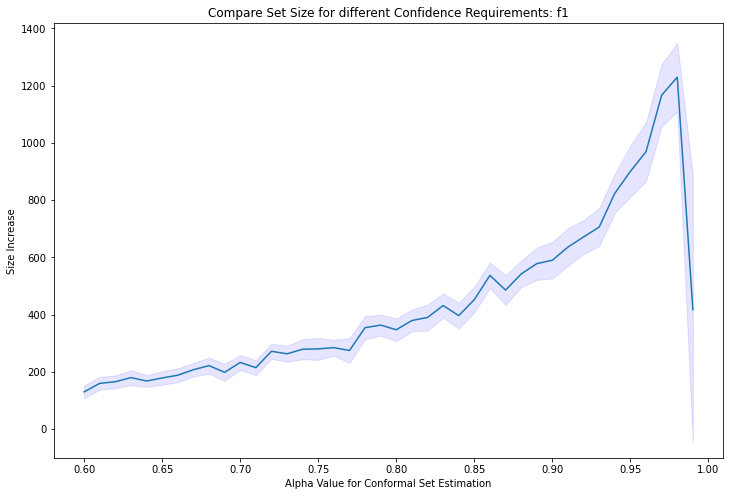

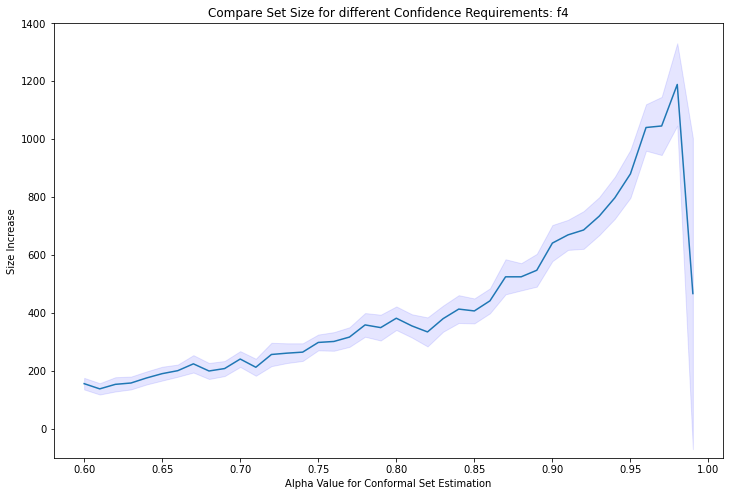

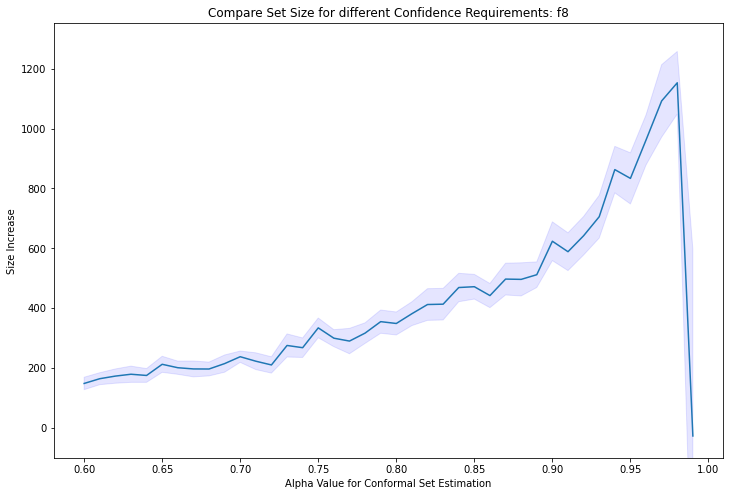

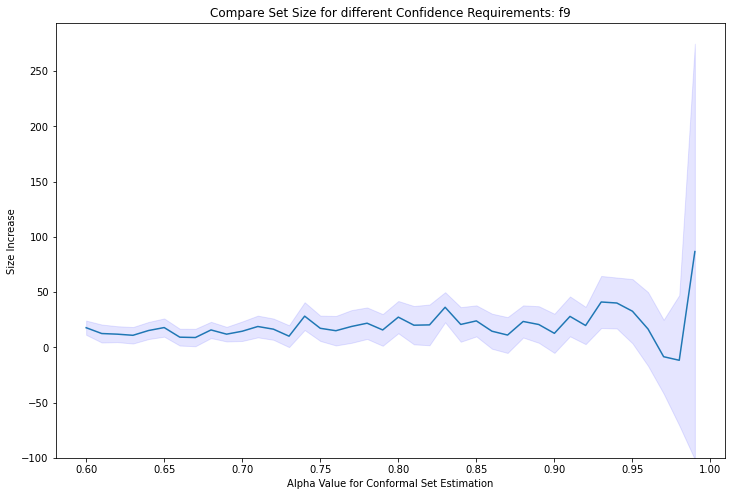

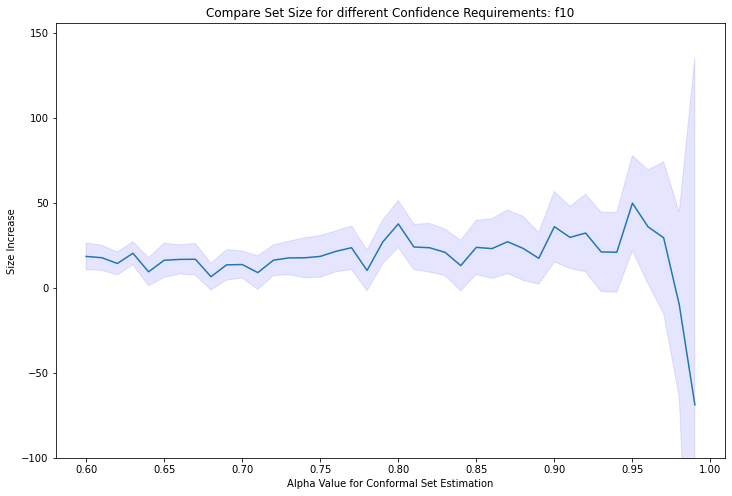

In [93]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    plt.figure(figsize=(12,8))
    ci = 1.96*np.std(np.array(ci_dict[variable]), axis=1)/np.sqrt(len(ci_dict[variable]))
    plt.plot(np.arange(0.6, 1, 0.01), average_size[variable])
    plt.fill_between(np.arange(0.6, 1, 0.01), (average_size[variable]-ci), (average_size[variable]+ci), color='b', alpha=.1)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.ylim(bottom=-100)
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable)
    plt.savefig('images/Multi_data_correct/alpha_grid_' + variable)
    plt.show();

In [99]:
# See if we can get any relation between accuracy decrease and set size increase for different RandomForest Models

B = 50

average_size = defaultdict(list)
accuracy_decrease = defaultdict(list)
ci_dict_size = {}
ci_dict_acc = {}

for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    print(variable)
    ci_size = []
    ci_acc = []

    for n_estimators in np.arange(1, 400, 20):
        print(n_estimators)
        temp = 0
        temp_acc = 0

        ci_temp_size = []
        ci_temp_acc = []

        for i in range(B):

            multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
            multi_data.X_y_split(y='y')

            model = RandomForestClassifier(n_estimators=n_estimators)
            model.fit(multi_data.train_data_X, multi_data.train_data_y)
            
            simple_conformal = SimpleConformal(alpha=1-alpha, type='adaptive')
            lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
            pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)
            cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=multi_data.test_data_y, plot=False)
            acc_all = model.score(multi_data.test_data_X, multi_data.test_data_y)

            data_X_j = copy.copy(multi_data.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(multi_data.test_data_X)
            data_X_test_j[variable] = 0

            lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
            pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)
            cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=multi_data.test_data_y, plot=False)
            acc_j = model.score(data_X_test_j, multi_data.test_data_y)

            temp += size_j-size_all
            temp_acc += acc_all-acc_j

            ci_temp_size.append(size_j-size_all)
            ci_temp_acc.append(acc_all-acc_j)

        average_size[variable].extend([temp/B])
        accuracy_decrease[variable].extend([temp_acc/B])

        ci_size.append(ci_temp_size)
        ci_acc.append(ci_temp_acc)
    
    ci_dict_size[variable] = ci_size
    ci_dict_acc[variable] = ci_acc

f1
1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
f4
1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
f8
1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
f9
1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
f10
1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381


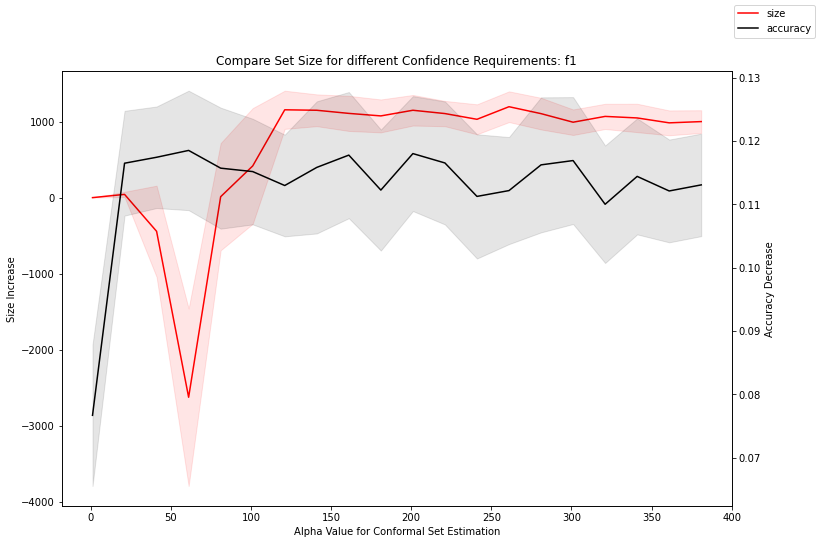

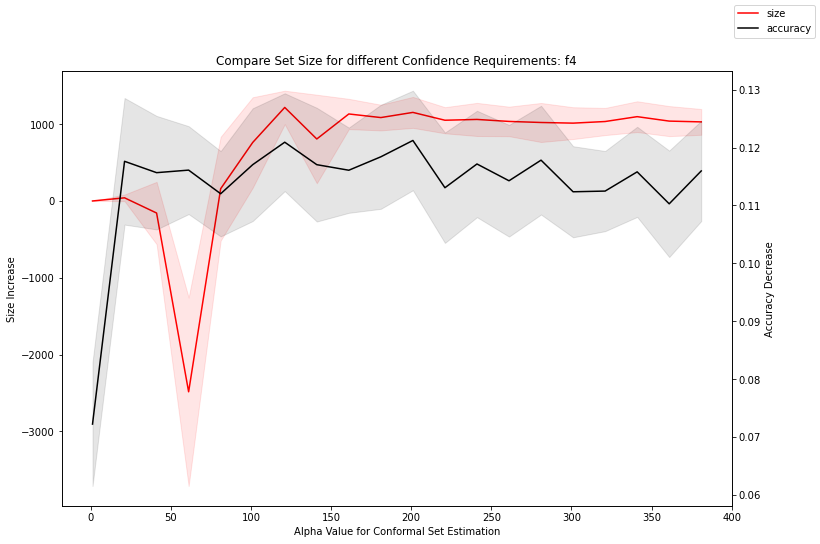

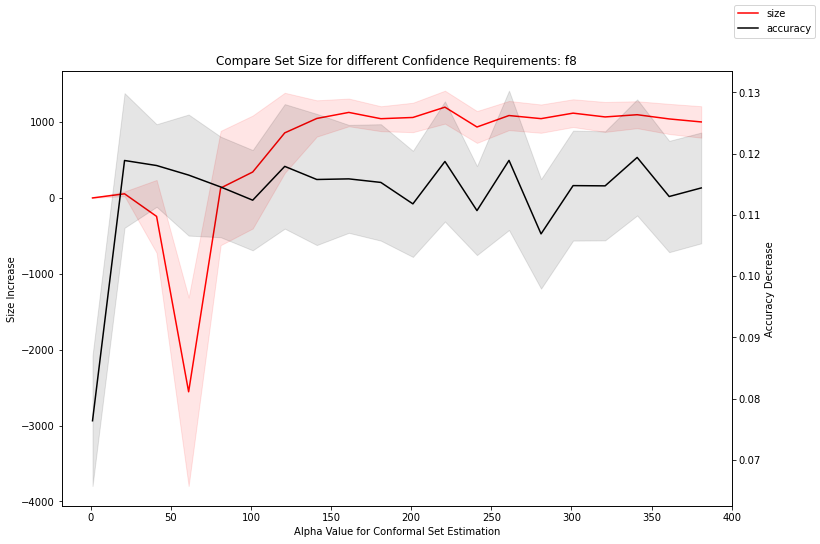

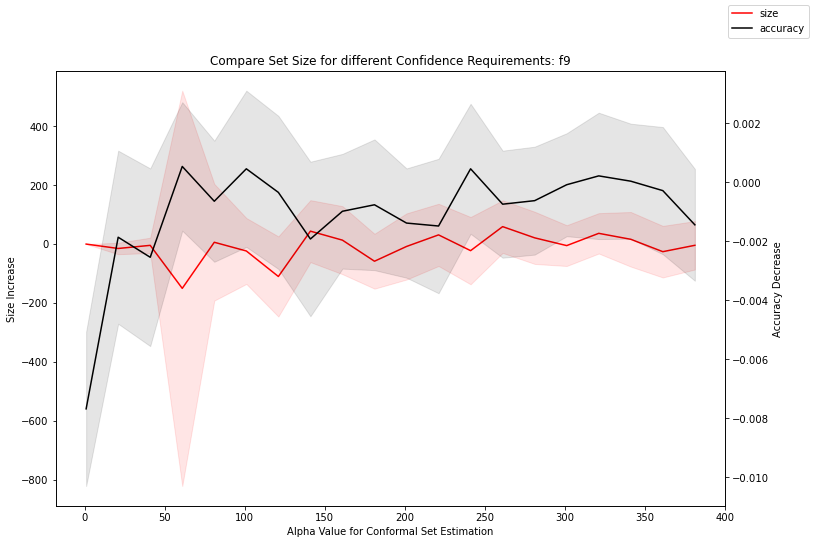

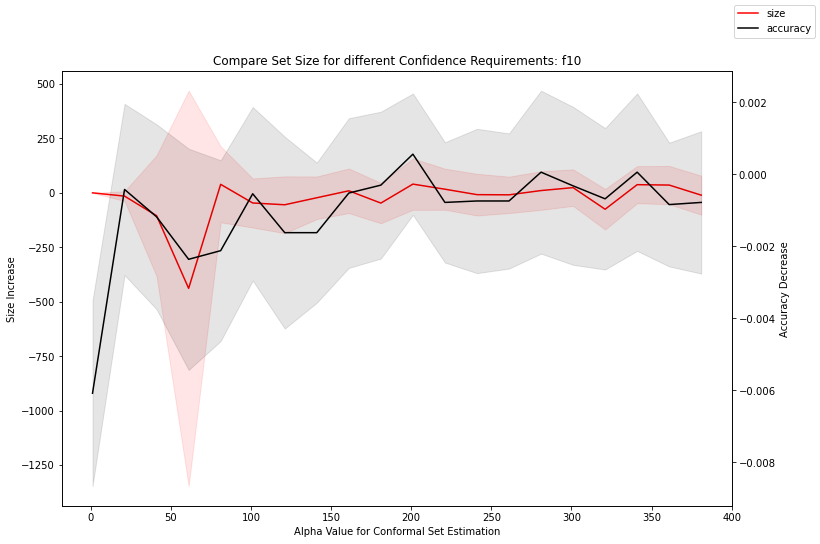

In [100]:
for variable in ['f1', 'f4', 'f8', 'f9', 'f10']:
    fig,ax = plt.subplots(figsize=(12,8))
    ci_size = 1.96*np.std(np.array(ci_dict_size[variable]), axis=1)/np.sqrt(len(ci_dict_size[variable]))
    ci_acc = 1.96*np.std(np.array(ci_dict_acc[variable]), axis=1)/np.sqrt(len(ci_dict_acc[variable]))
    plt.plot(np.arange(1, 400, 20), average_size[variable], color='red', label='size')
    plt.fill_between(np.arange(1, 400, 20), (average_size[variable]-ci_size), (average_size[variable]+ci_size), color='red', alpha=.1)
    ax.set_ylabel('Size Increase')
    ax.set_xlabel('Alpha Value for Conformal Set Estimation')
    ax2=ax.twinx()
    ax2.plot(np.arange(1, 400, 20), accuracy_decrease[variable], color='black', label='accuracy')
    ax2.fill_between(np.arange(1, 400, 20), (accuracy_decrease[variable]-ci_acc), (accuracy_decrease[variable]+ci_acc), color='black', alpha=.1)
    ax2.set_ylabel('Accuracy Decrease')
    ax.set_title('Compare Set Size for different Confidence Requirements: ' + variable)
    fig.legend()
    plt.savefig('images/Multi_data_correct/model_performance_' + variable)
    plt.show();

In [34]:
# What is the distribution of conformal for each true class?

# TODO: Also include some kind of confidence band intervals
alpha = 0.05
B = 2
class_all = defaultdict(list)
class_vars = defaultdict(lambda: defaultdict(list))

for i in range(B):






    

    print(i)

    multi_data = MultiClass(n=10000, n_features=10, n_informative=8, n_classes=10)
    multi_data.X_y_split(y='y')

    model = RandomForestClassifier()
    model.fit(multi_data.train_data_X, multi_data.train_data_y)
    
    simple_conformal = SimpleConformal(alpha=alpha, type='adaptive')
    lambda_all = simple_conformal.calibrate(data_X=multi_data.calib_data_X, data_y=multi_data.calib_data_y, model=model)
    pred_all = simple_conformal.predict(data=multi_data.test_data_X, model=model, lambda_conformal=lambda_all)

    for j, pred in enumerate(pred_all):
        class_all[multi_data.test_data_y.iloc[j]].extend([pred])

    for variable in multi_data.train_data_X.columns:

        data_X_j = copy.copy(multi_data.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(multi_data.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=multi_data.calib_data_y, model=model)
        pred_j = simple_conformal.predict(data=data_X_test_j, model=model, lambda_conformal=lambda_j)

        for j, pred in enumerate(pred_j):
            class_vars[variable][multi_data.test_data_y.iloc[j]].extend([pred])


0
1


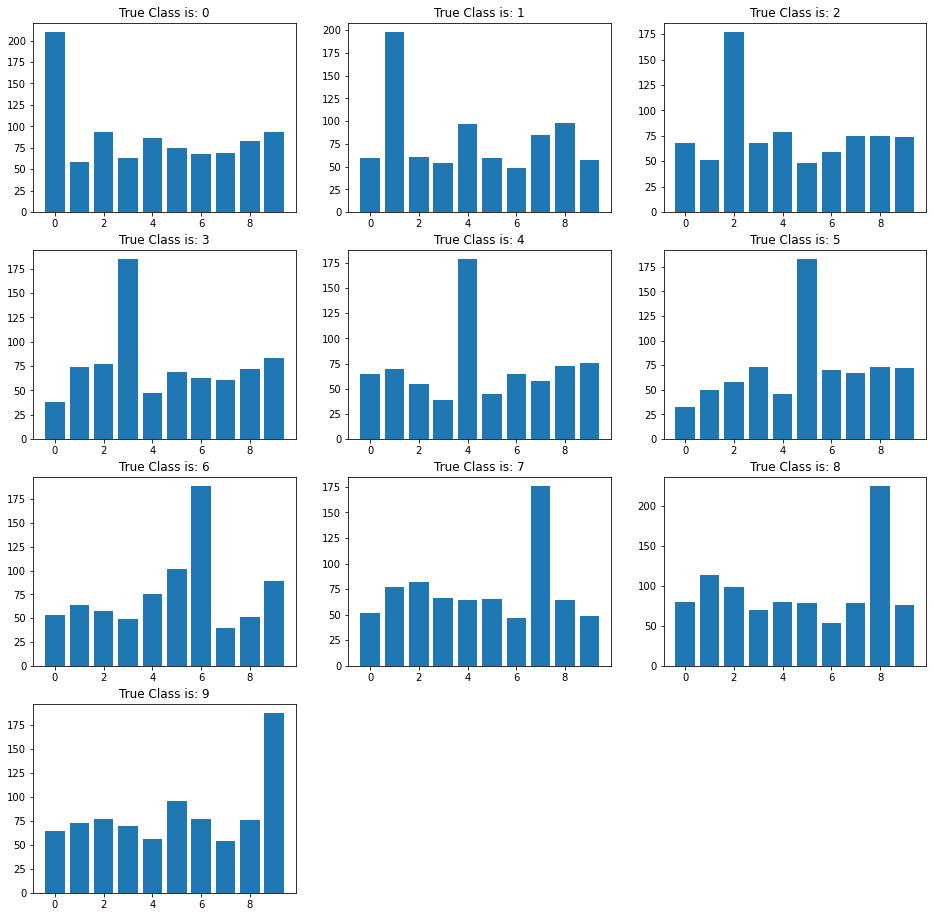

In [51]:
from collections import Counter

def flatten(t):
    return [item for sublist in t for item in sublist]

k = 0
plt.figure(figsize=(16, 16))
for i in range(4):
    for j in range(3):
        ax = plt.subplot2grid((4,3), (i,j))
        c = Counter(flatten(class_all[k]))
        ax.bar(c.keys(), c.values())
        ax.set_title('True Class is: ' + str(k))
        k+=1
        if k == 10:
            break
plt.savefig('images/Multi_data_correct/conformal_set_distribution_all')
plt.show()


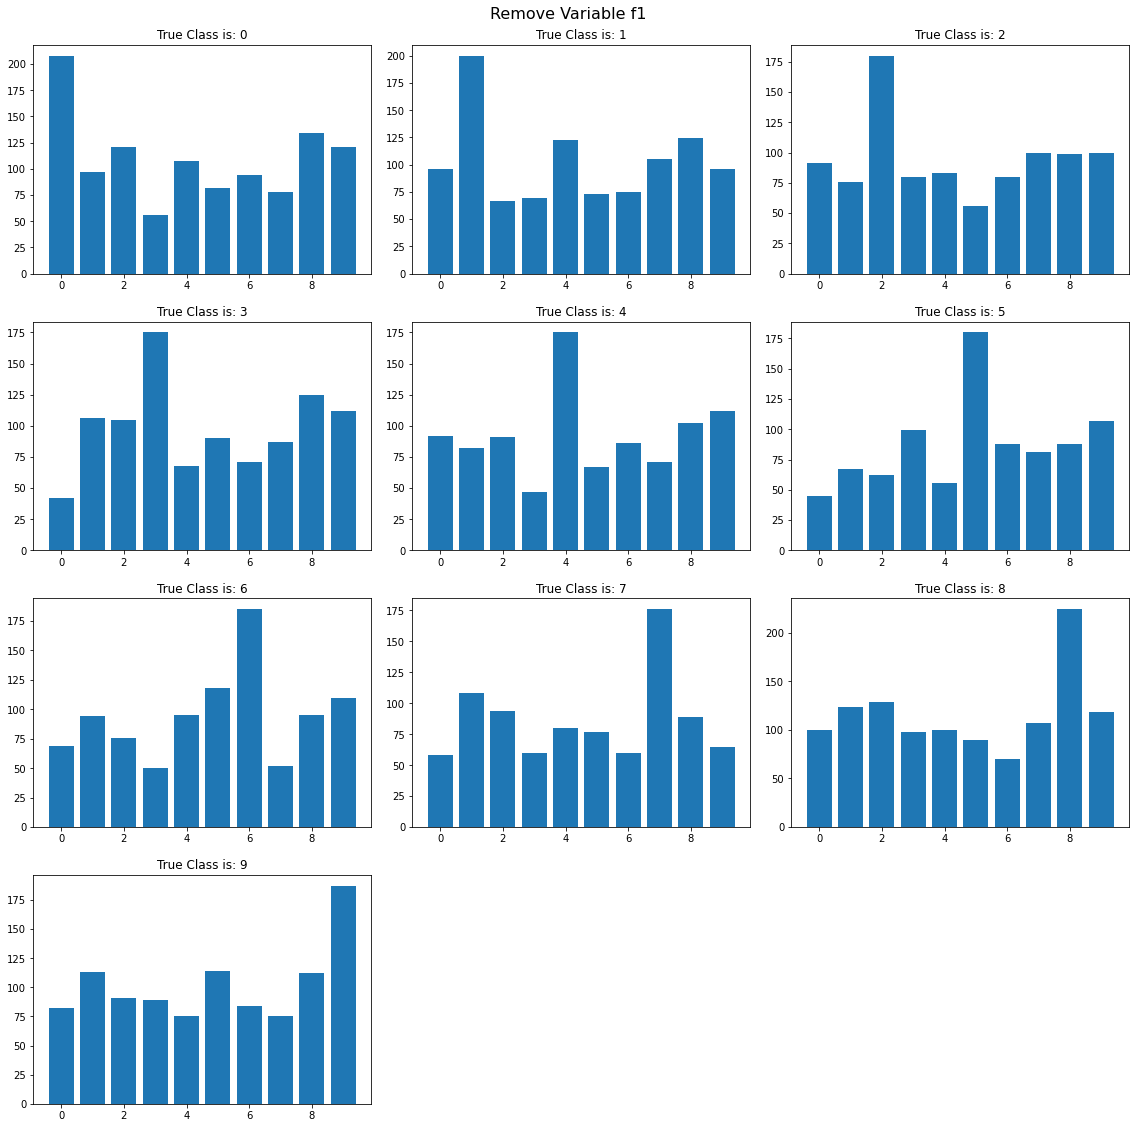

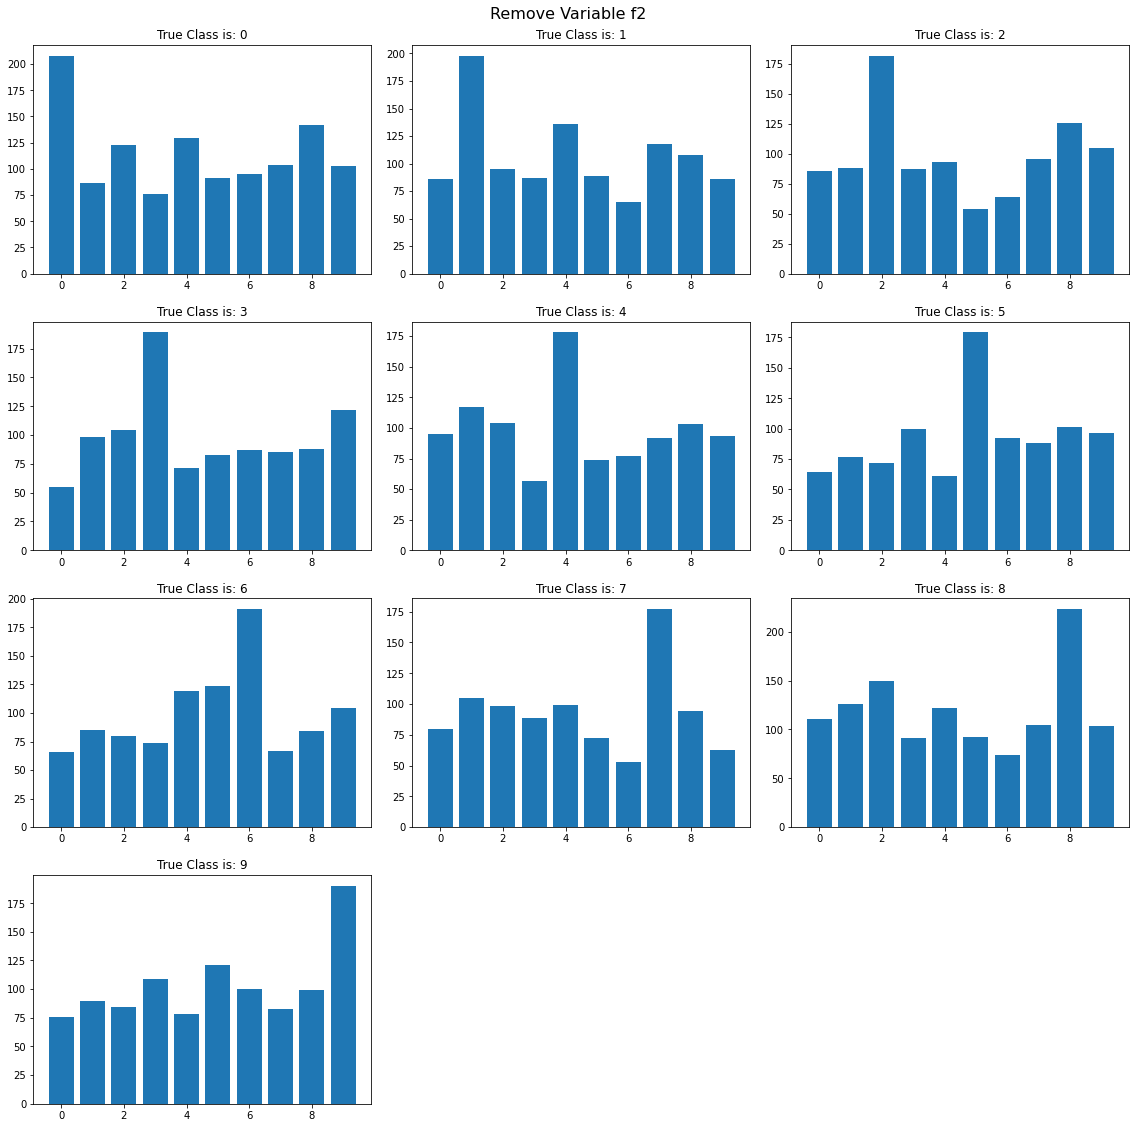

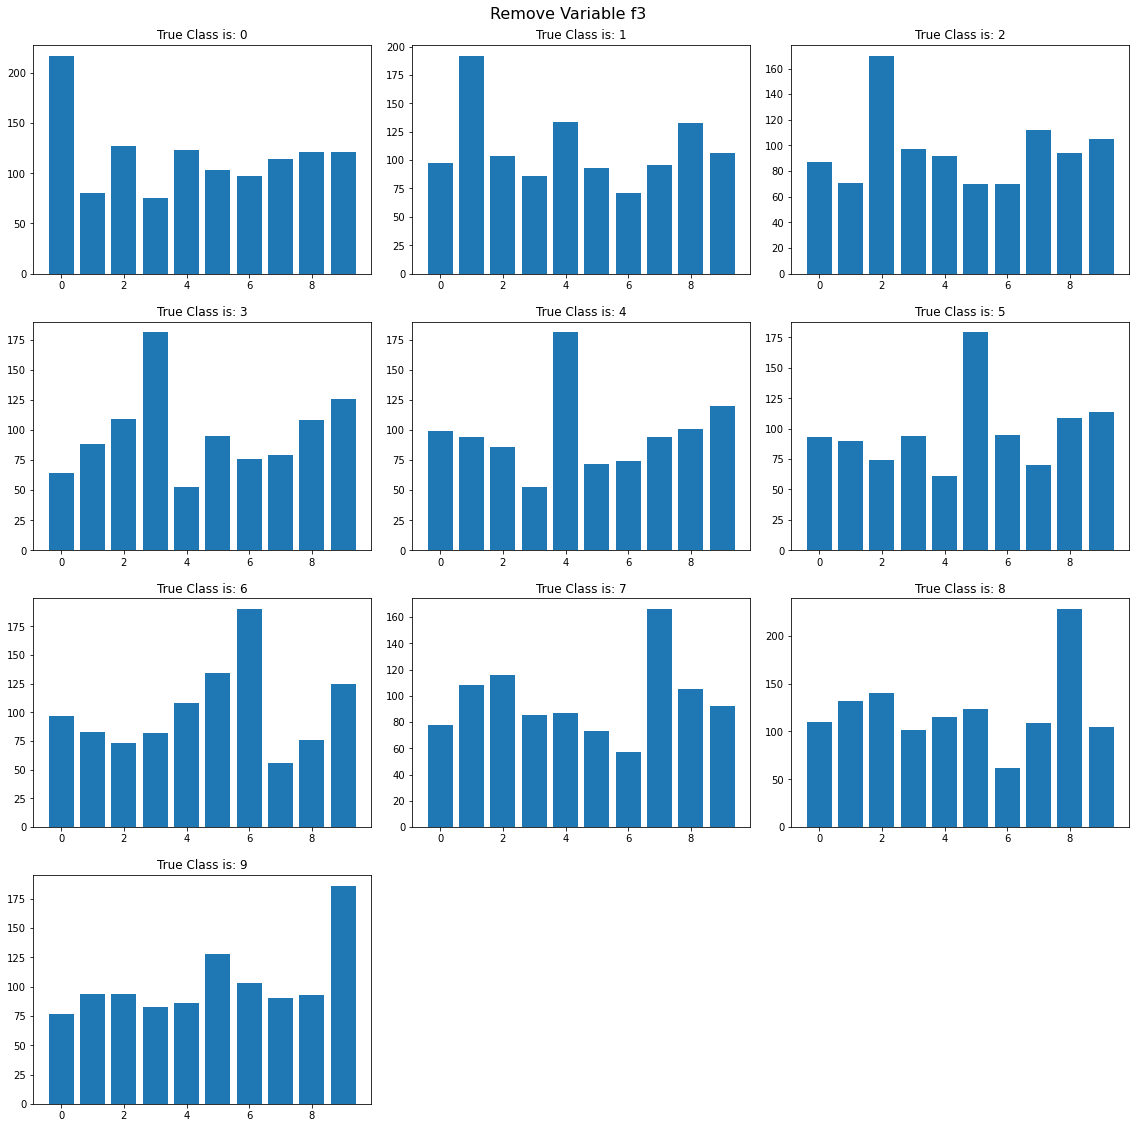

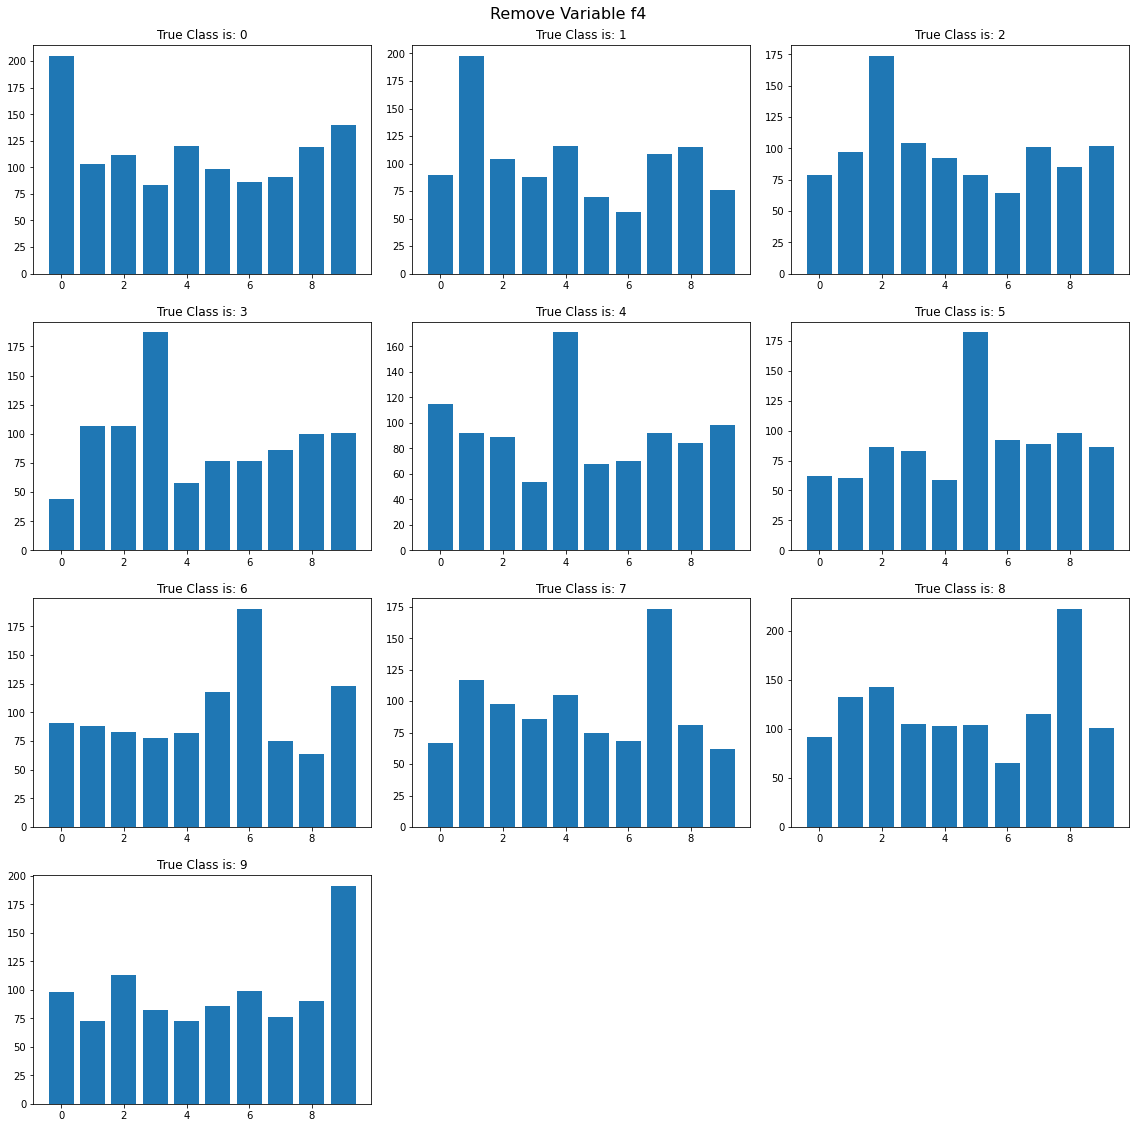

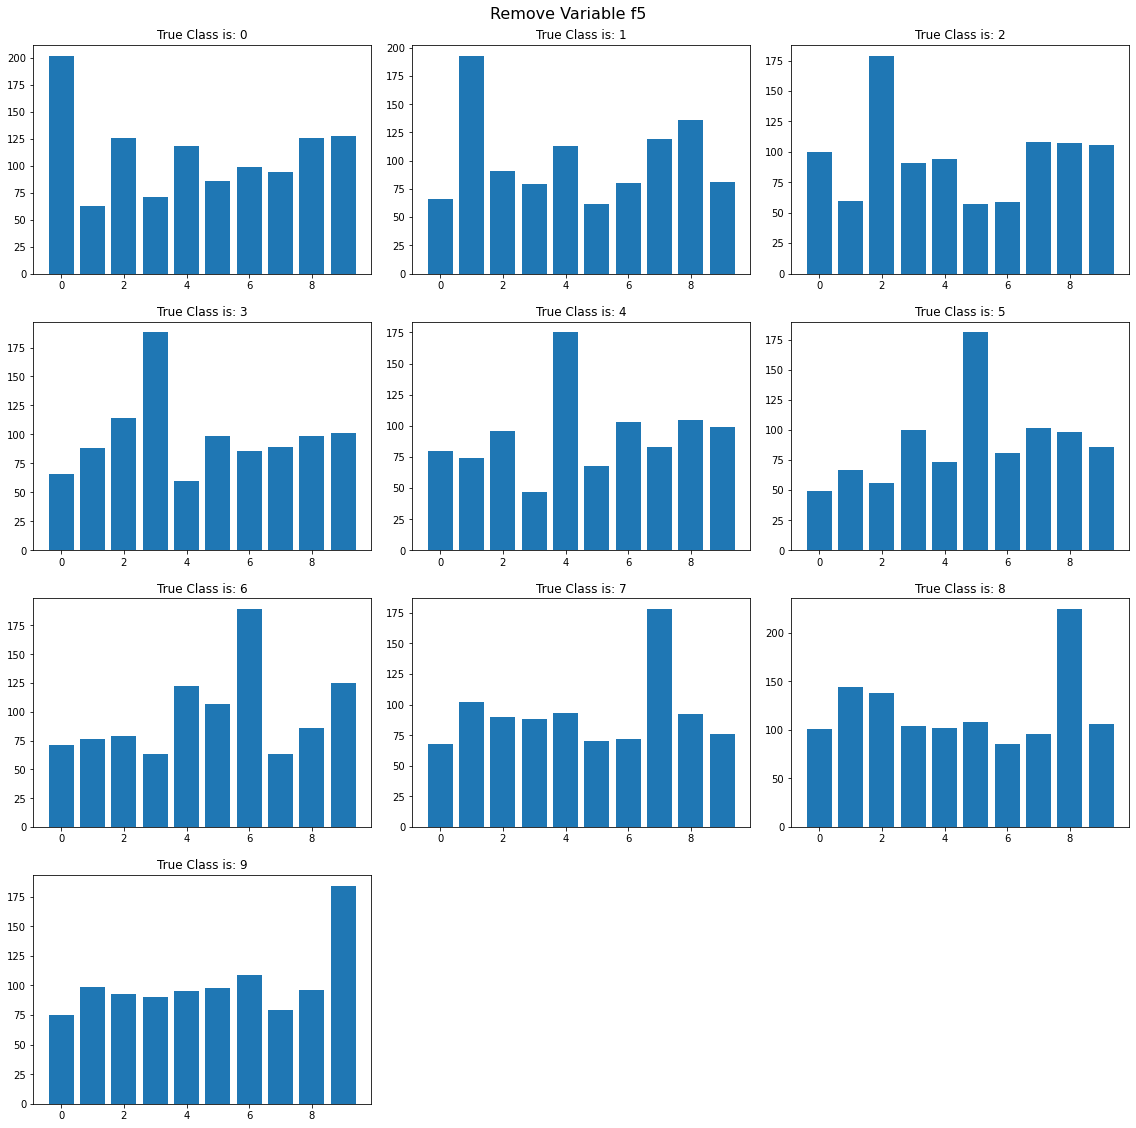

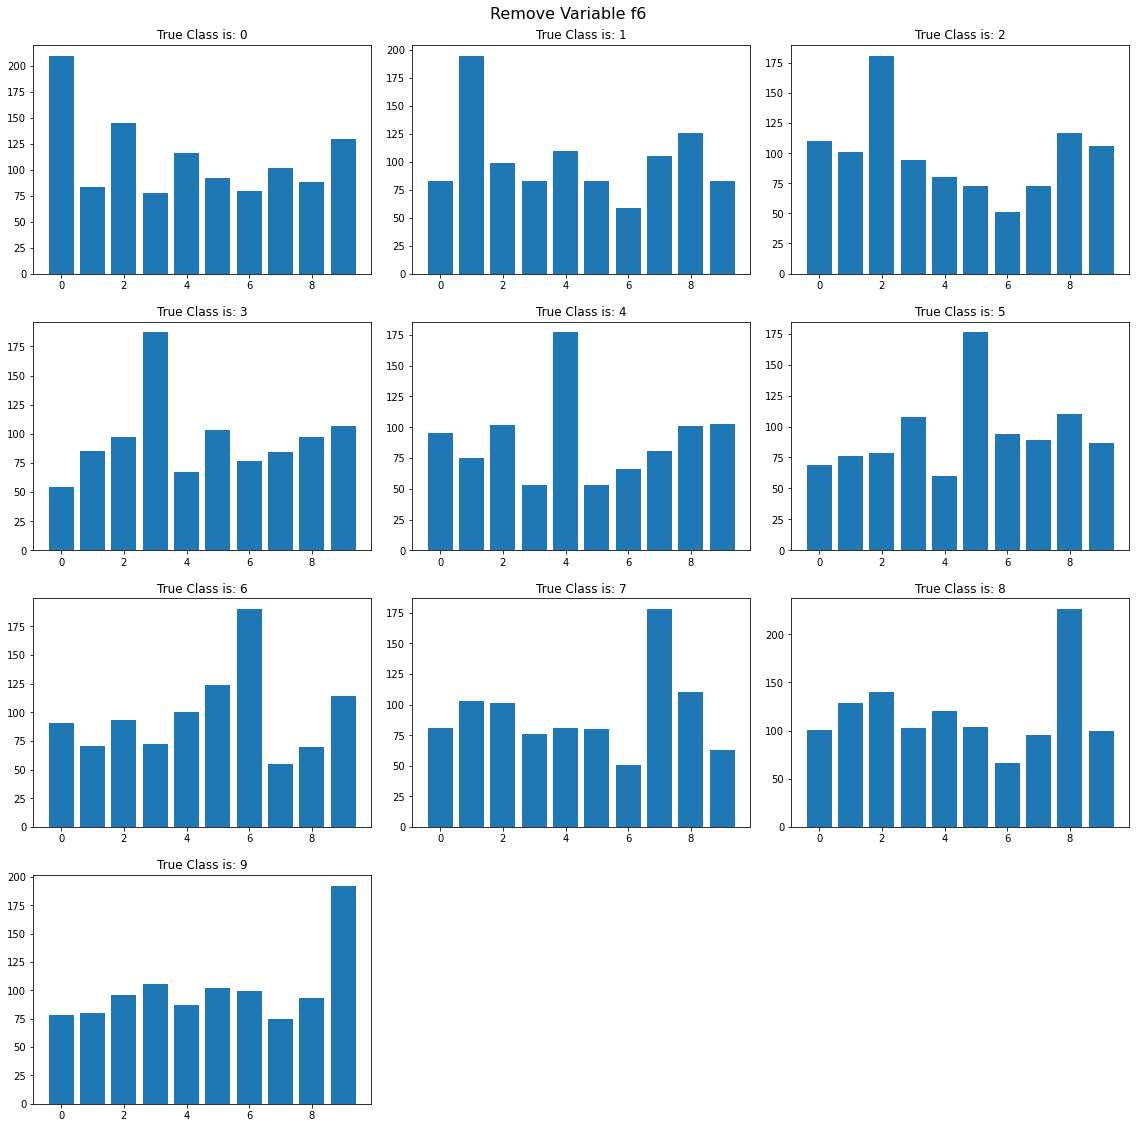

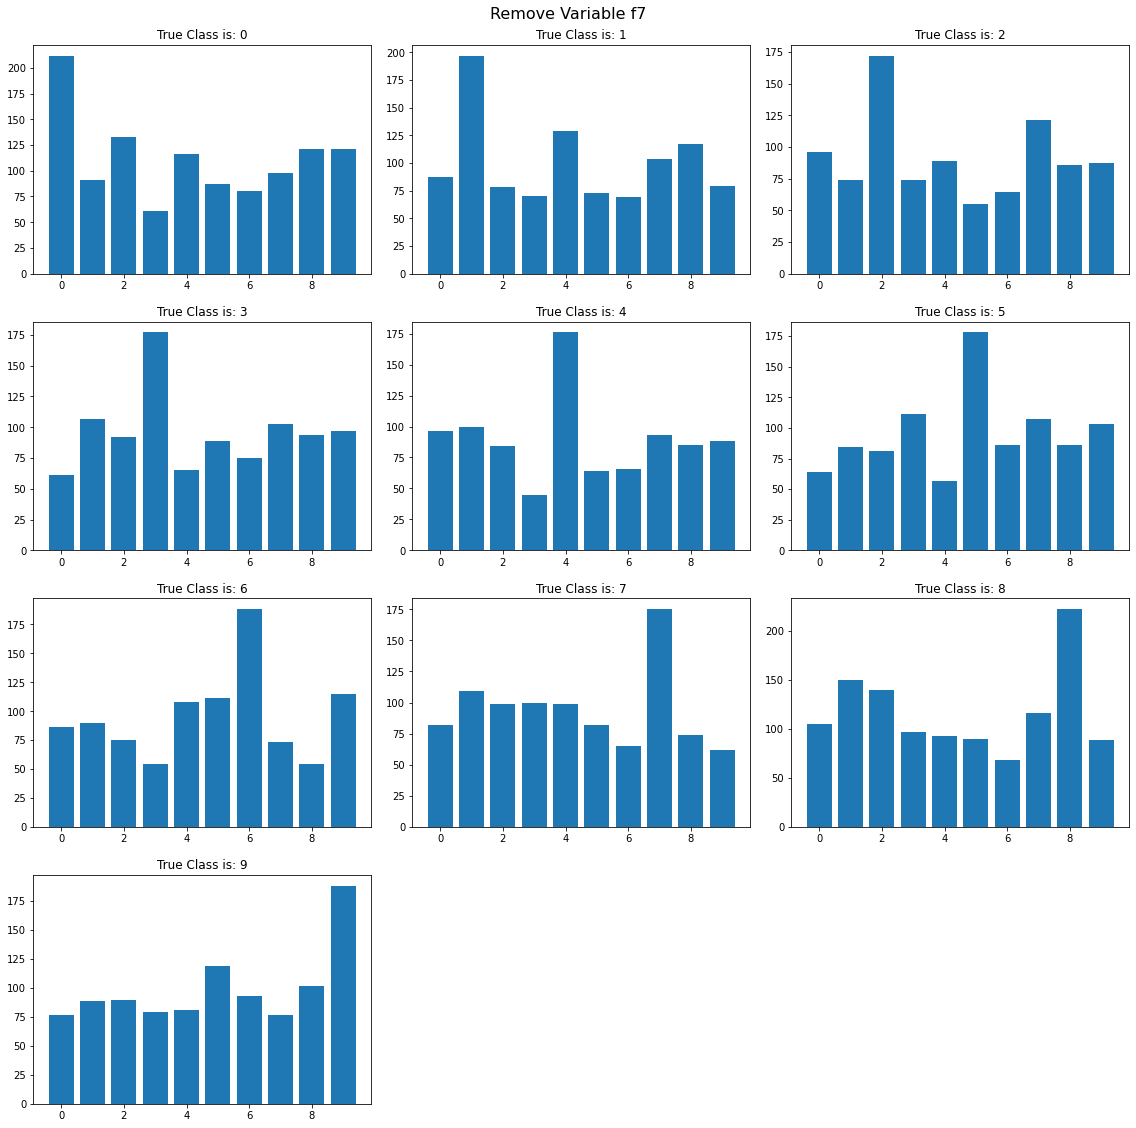

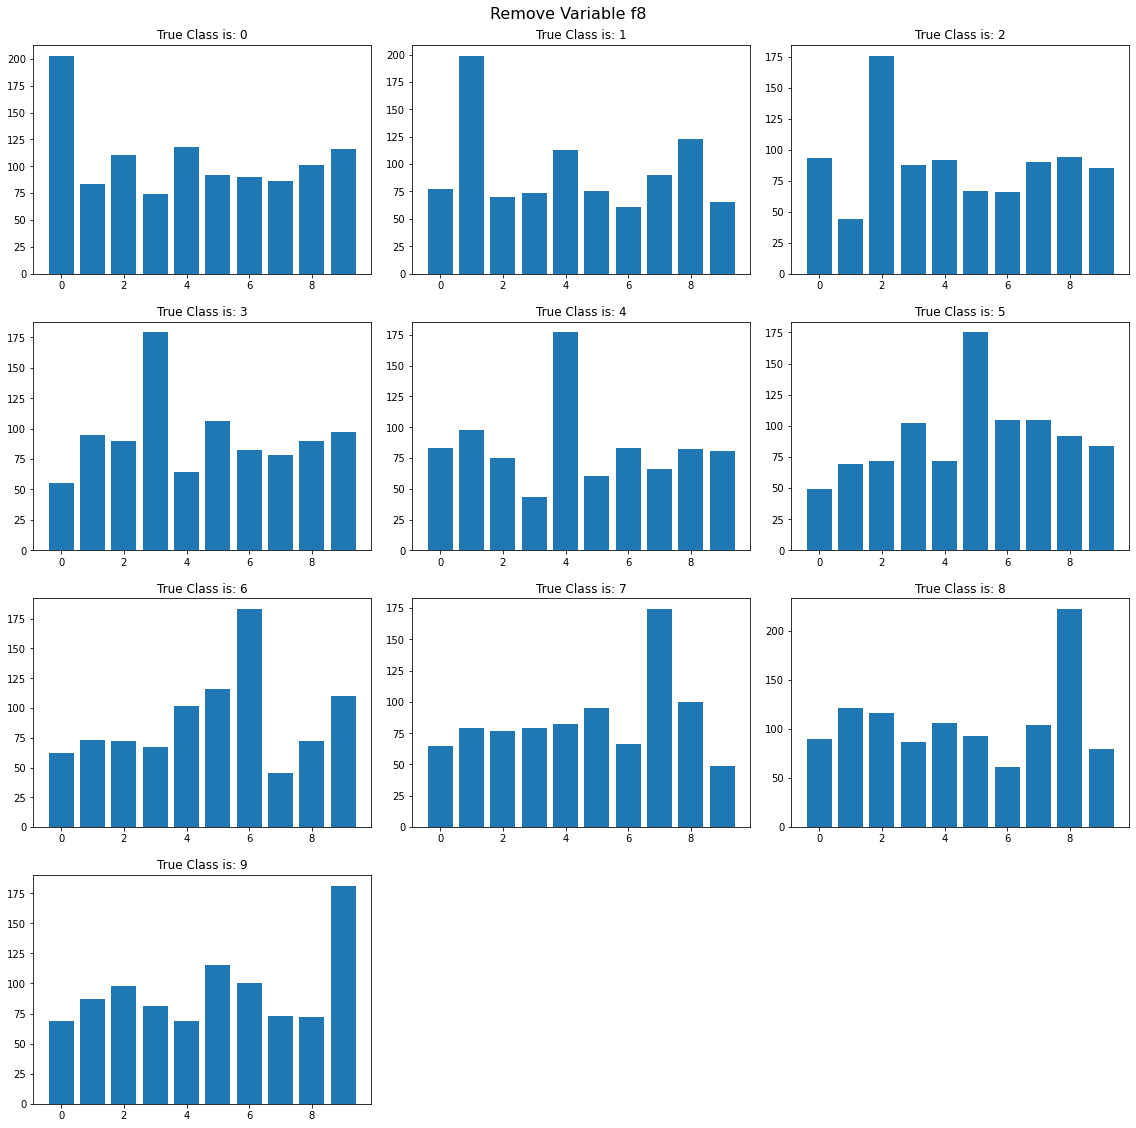

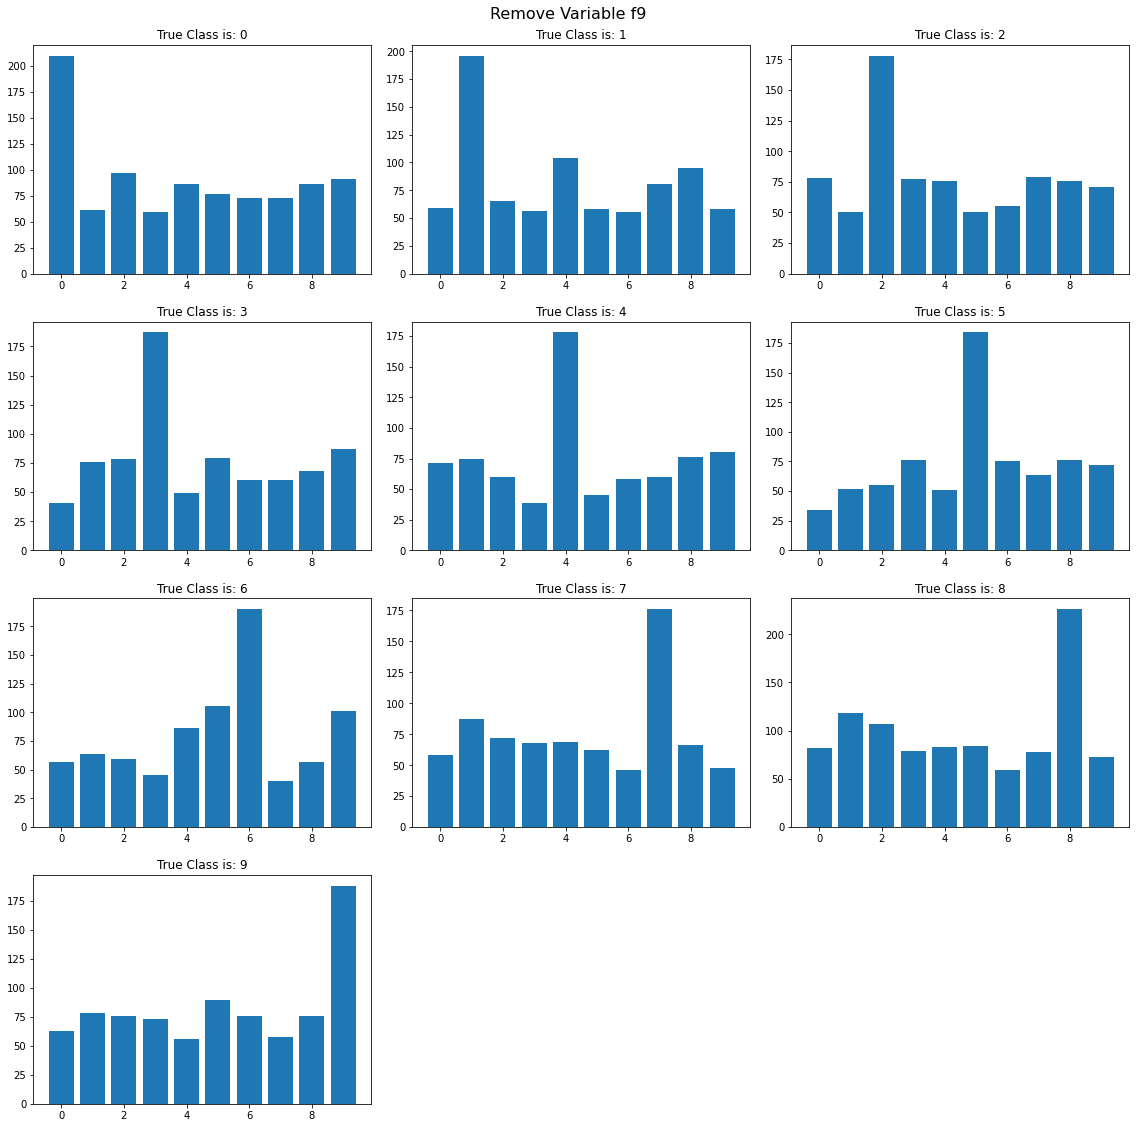

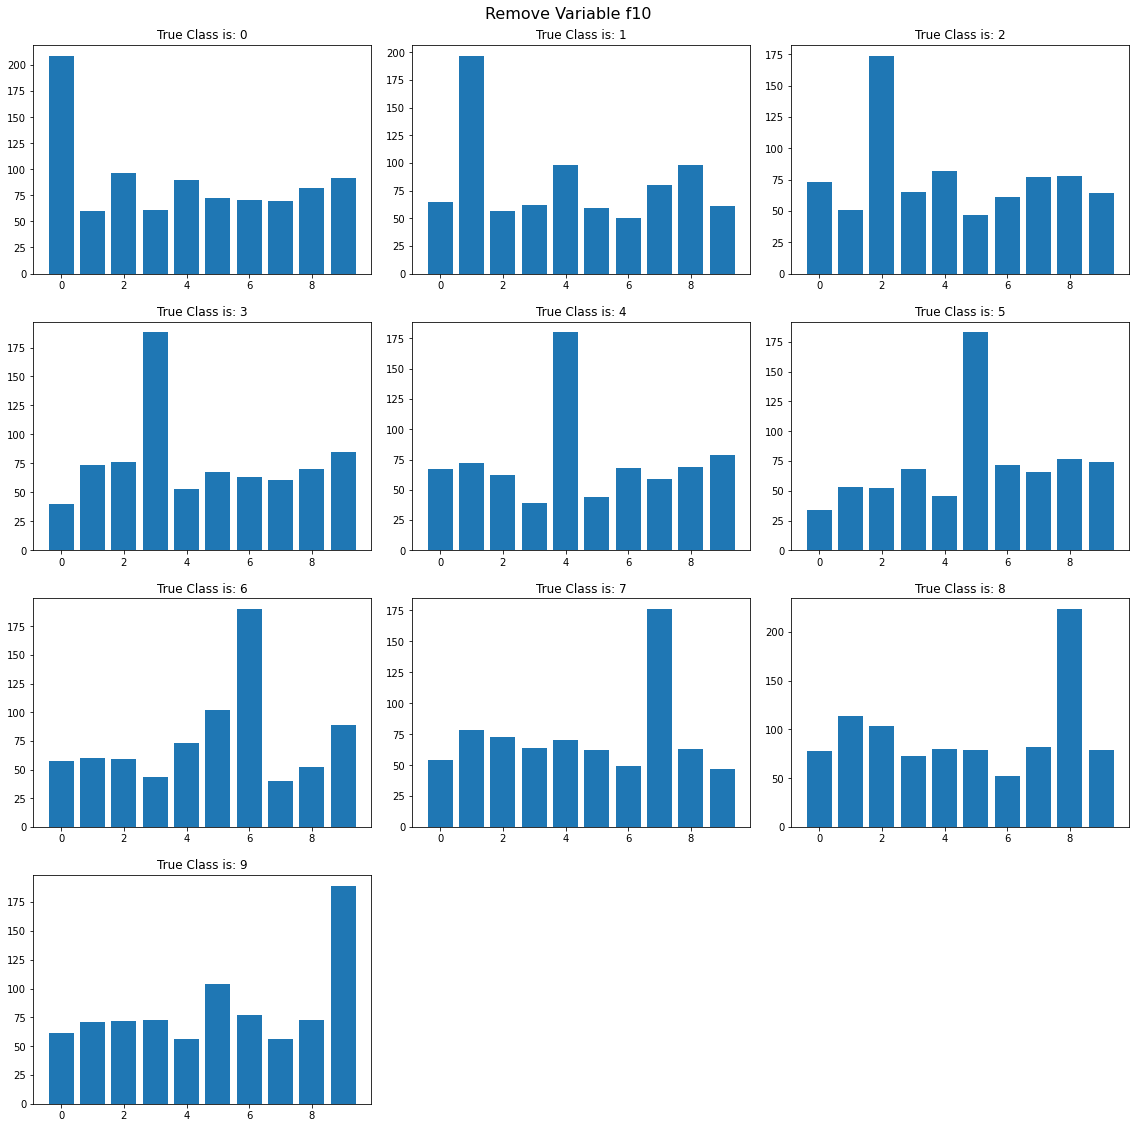

In [59]:
for variable in multi_data.train_data_X.columns:
    k = 0
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    for n, ax in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):

            if n == 9:
                n = 10

            ax = plt.subplot(4, 3, n + 1)

            true = dict(sorted(Counter(np.array(flatten(class_all[k]))).items()))
            x = np.array(flatten(class_vars[variable][k]))

            ax.hist(x, bins=np.arange(11) - 0.5, rwidth=0.85)
            ax.hlines(0, xmin=-1, xmax=10, linestyles='--', colors='r')
            ax.plot(list(true.keys()), list(true.values()), "g-")

            low = 0
            for i, rectangle in enumerate(ax.patches):

                # expected value in the middle of the bar
                exp = list(true.values())[i]

                # difference to the expected value
                diff = exp - rectangle.get_height()
                rectangle.set_y(diff)

                ax.plot(rectangle.get_x() + rectangle.get_width()/2., exp, "go")
                low = min(low, diff)

            ax.set_ylim(bottom=low-10)
            ax.set_xticks(range(10))
            ax.set_title('True Class is: ' + str(k))
            k+=1
            if k == 10:
                break

    plt.suptitle('Remove Variable ' + variable, size=16)
    plt.tight_layout(pad=1.50)
    plt.savefig('images/Multi_data_correct/conformal_set_distribution_'+ variable)
    plt.show()

In [ ]:
# What is the maximum change we can apply on each variables (independently) such that the conformal prediction remains the same?
dict_store = defaultdict(int)
step = 0.05
max_iter = 300
cols = list(multi_data.train_data_X.columns)

for obs in range(500):
    print((obs/500)*100)
    pred_all = simple_conformal.predict(data=multi_data.test_data_X[obs:obs+1], model=model, lambda_conformal=lambda_all)
    for i, variable in enumerate(multi_data.train_data_X.columns):
        features_up = copy.copy(multi_data.test_data_X.iloc[obs].tolist())
        features_down = copy.copy(multi_data.test_data_X.iloc[obs].tolist())
        step_up = 0
        count = 0
        while True:
            features_up[i] = features_up[i] + step
            data_up = pd.DataFrame([np.array(features_up)], columns=cols)
            pred_up = simple_conformal.predict(data=data_up, model=model, lambda_conformal=lambda_all)
            step_up += step
            count += 1
            if (len(pred_up[0]) > len(pred_all[0])) | (count > max_iter):
                dict_store[variable + 'up'] += step_up
                break
        step_down = 0
        count = 0
        while True:
            features_down[i] = features_down[i] - step
            data_down = pd.DataFrame([np.array(features_down)], columns=cols)
            pred_down = simple_conformal.predict(data=data_down, model=model, lambda_conformal=lambda_all)
            step_down += step
            count += 1
            if (len(pred_down[0]) > len(pred_all[0])) | (count > max_iter):
                dict_store[variable + 'down'] += step_down
                break

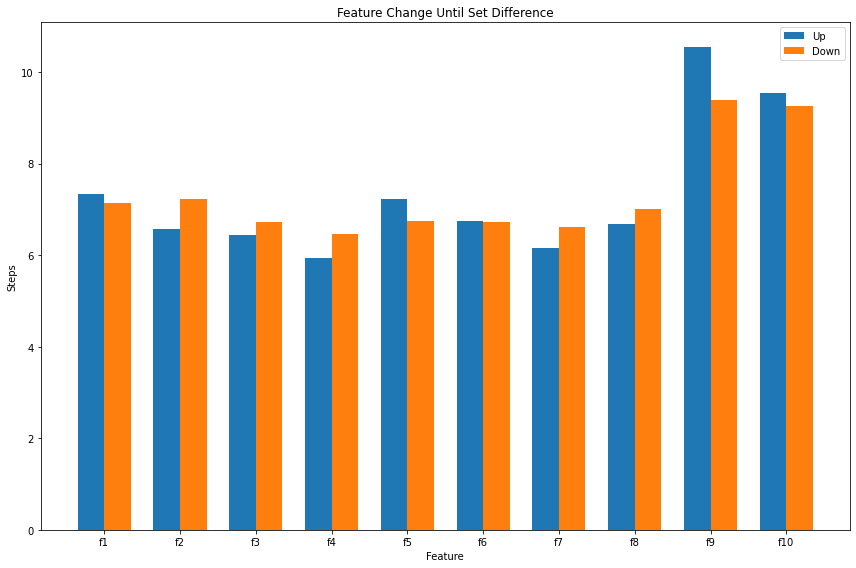

In [68]:
labels = list(multi_data.train_data_X.columns)
l = list(dict_store.values())
up = [l[i]/500 for i in np.arange(0, len(l), 2)]
down = [l[i]/500 for i in np.arange(1, len(l)+1, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, up, width, label='Up')
rects2 = ax.bar(x + width/2, down, width, label='Down')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Feature')
ax.set_ylabel('Steps')
ax.set_title('Feature Change Until Set Difference')
ax.set_xticks(ticks=x)
ax.set_xticklabels( labels=labels)
ax.legend()

fig.tight_layout()
plt.savefig('images/Multi_data_correct/perturbation.png')
plt.show()